### データ入力

In [1]:
from src.tsplib_data import load_data

In [2]:
file_name = 'eil51.tsp'

In [3]:
data = load_data(file_name=file_name)
data

TSP(file_name='eil51', edge_weight_type='EUC_2D', dimension=51, coordinate={1: [37, 52], 2: [49, 49], 3: [52, 64], 4: [20, 26], 5: [40, 30], 6: [21, 47], 7: [17, 63], 8: [31, 62], 9: [52, 33], 10: [51, 21], 11: [42, 41], 12: [31, 32], 13: [5, 25], 14: [12, 42], 15: [36, 16], 16: [52, 41], 17: [27, 23], 18: [17, 33], 19: [13, 13], 20: [57, 58], 21: [62, 42], 22: [42, 57], 23: [16, 57], 24: [8, 52], 25: [7, 38], 26: [27, 68], 27: [30, 48], 28: [43, 67], 29: [58, 48], 30: [58, 27], 31: [37, 69], 32: [38, 46], 33: [46, 10], 34: [61, 33], 35: [62, 63], 36: [63, 69], 37: [32, 22], 38: [45, 35], 39: [59, 15], 40: [5, 6], 41: [10, 17], 42: [21, 10], 43: [5, 64], 44: [30, 15], 45: [39, 10], 46: [32, 39], 47: [25, 32], 48: [25, 55], 49: [48, 28], 50: [56, 37], 51: [30, 40]})

### 前処理

In [4]:
from src.pre_processing import PreProcessing

In [5]:
pre_processing = PreProcessing()

#### 地点間の距離マトリクスを取得

In [6]:
dist_matrix = pre_processing.get_dist_matrix(data)
dist_matrix

array([[ 0., 12., 19., ..., 26., 24., 14.],
       [12.,  0., 15., ..., 21., 14., 21.],
       [19., 15.,  0., ..., 36., 27., 33.],
       ...,
       [26., 21., 36., ...,  0., 12., 22.],
       [24., 14., 27., ..., 12.,  0., 26.],
       [14., 21., 33., ..., 22., 26.,  0.]])

### 定式化・モデル生成機能

In [7]:
from src.model import TspModel

In [8]:
tsp_model = TspModel()

#### 数理モデル、重み、QUBO生成

In [9]:
model = tsp_model.get_model(data, dist_matrix)

In [10]:
feed_dict = tsp_model.get_feed(s1=1.0, p1=0.5, p2=0.5, p3=10.0)

In [11]:
qubo, offset = tsp_model.to_qubo(model=model, feed_dict=feed_dict)

### アニーリング

In [12]:
sampleset = tsp_model.annealing(sampler="neal",qubo=qubo, num_reads=1, num_sweeps=20000)

In [13]:
checks = tsp_model.check(model, sampleset, feed_dict)
checks

[{}]

In [14]:
sample = sampleset.record[0][0].reshape(data.dimension, data.dimension)
sample

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

### 後処理

In [15]:
from src.post_proceesing import PostProcessing

In [16]:
post_proceesing = PostProcessing()

In [17]:
def display_actual_distance(data, id_sequence):
    """目的関数の実測値を表示

    Args:
        data (tsplib_data.TSP): TSPデータ
        id_sequence (list): アニーリングで採用された地点ID
    """
    between_two_point_dists = {}
    total_distance = 0.0
    for i in range(data.dimension):
        key = f"{id_sequence[i]} -> {id_sequence[i+1]}"
        dist = pre_processing.get_dist(data.edge_weight_type, data.coordinate[id_sequence[i]], data.coordinate[id_sequence[i+1]])
        between_two_point_dists[key] = dist
        total_distance += dist

    print("between_two_point_dists: ", between_two_point_dists)
    print("total_distance: " , total_distance)

#### 量子アニーリング結果の可視化

In [18]:
id_sequence = post_proceesing.get_result_city_id(data, sample)

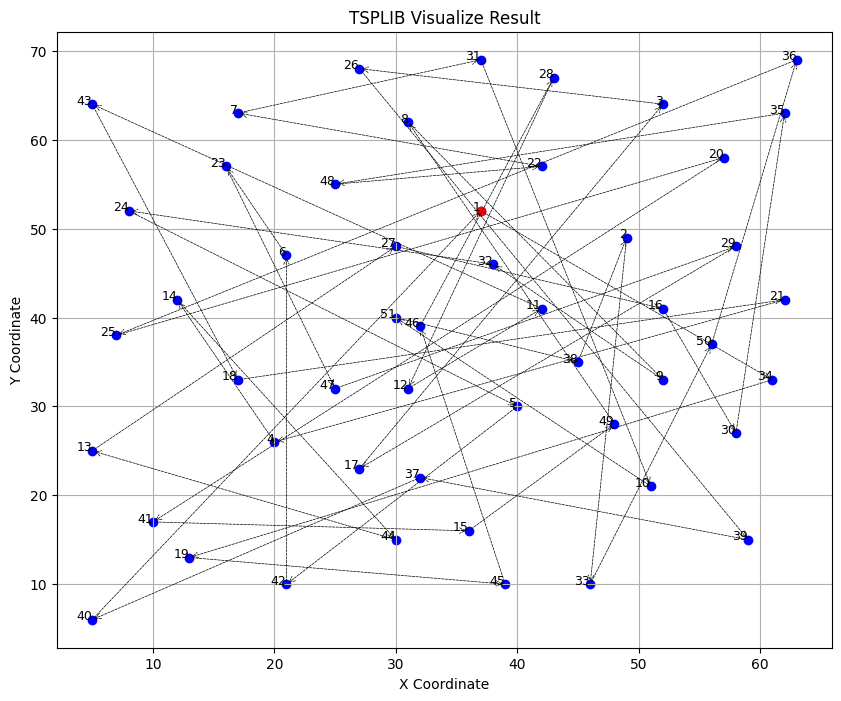

between_two_point_dists:  {'1 -> 34': 31, '34 -> 19': 52, '19 -> 45': 26, '45 -> 46': 30, '46 -> 28': 30, '28 -> 12': 37, '12 -> 11': 14, '11 -> 43': 44, '43 -> 18': 33, '18 -> 21': 46, '21 -> 4': 45, '4 -> 14': 18, '14 -> 44': 32, '44 -> 13': 27, '13 -> 27': 34, '27 -> 16': 23, '16 -> 30': 15, '30 -> 35': 36, '35 -> 48': 38, '48 -> 22': 17, '22 -> 7': 26, '7 -> 31': 21, '31 -> 10': 50, '10 -> 51': 28, '51 -> 38': 16, '38 -> 2': 15, '2 -> 33': 39, '33 -> 50': 29, '50 -> 36': 33, '36 -> 25': 64, '25 -> 20': 54, '20 -> 41': 62, '41 -> 15': 26, '15 -> 49': 17, '49 -> 8': 38, '8 -> 9': 36, '9 -> 32': 19, '32 -> 24': 31, '24 -> 5': 39, '5 -> 42': 28, '42 -> 6': 37, '6 -> 23': 11, '23 -> 47': 27, '47 -> 29': 37, '29 -> 17': 40, '17 -> 3': 48, '3 -> 26': 25, '26 -> 39': 62, '39 -> 37': 28, '37 -> 40': 31, '40 -> 1': 56}
total_distance:  1701.0


In [19]:
post_proceesing.plot_route(data, id_sequence)
display_actual_distance(data, id_sequence)

#### 補足: 正解データ(期待値)の可視化

In [20]:
# 正解データ
if data.file_name == 'burma14':
    id_sequence = [1,10,9,11,8,13,7,12,6,5,4,3,14,2,1]
elif data.file_name == 'eil51':
    id_sequence = [
        1, 22, 8, 26, 31, 28, 3, 36, 35, 20,
        2, 29, 21, 16, 50, 34, 30, 9, 49, 10,
        39, 33, 45, 15, 44, 42, 40, 19, 41, 13,
        25, 14, 24, 43, 7, 23, 48, 6, 27, 51,
        46, 12, 47, 18, 4, 17, 37, 5, 38, 11, 32, 1
    ]

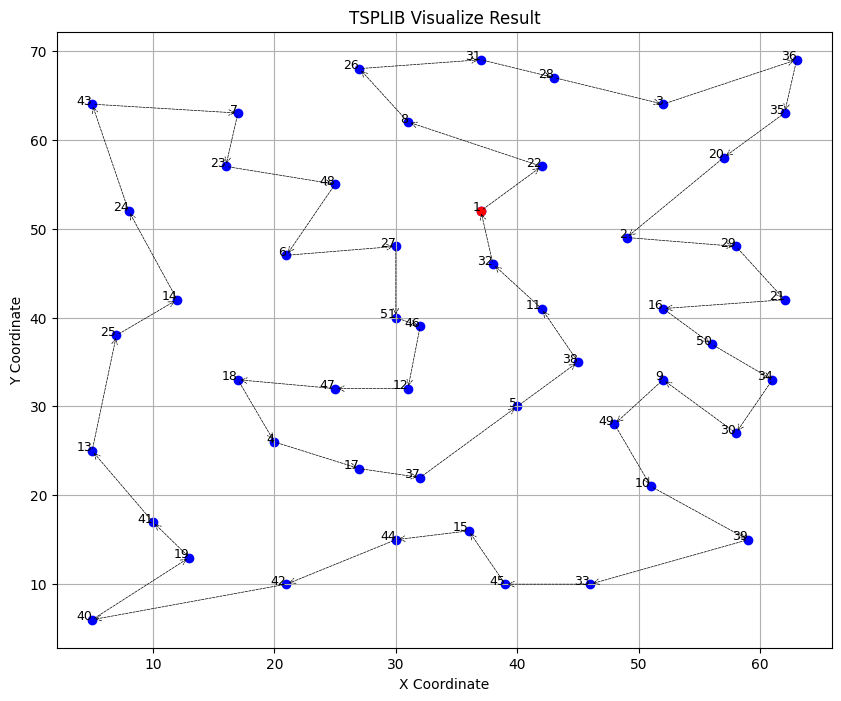

between_two_point_dists:  {'1 -> 22': 7, '22 -> 8': 12, '8 -> 26': 7, '26 -> 31': 10, '31 -> 28': 6, '28 -> 3': 9, '3 -> 36': 12, '36 -> 35': 6, '35 -> 20': 7, '20 -> 2': 12, '2 -> 29': 9, '29 -> 21': 7, '21 -> 16': 10, '16 -> 50': 6, '50 -> 34': 6, '34 -> 30': 7, '30 -> 9': 8, '9 -> 49': 6, '49 -> 10': 8, '10 -> 39': 10, '39 -> 33': 14, '33 -> 45': 7, '45 -> 15': 7, '15 -> 44': 6, '44 -> 42': 10, '42 -> 40': 16, '40 -> 19': 11, '19 -> 41': 5, '41 -> 13': 9, '13 -> 25': 13, '25 -> 14': 6, '14 -> 24': 11, '24 -> 43': 12, '43 -> 7': 12, '7 -> 23': 6, '23 -> 48': 9, '48 -> 6': 9, '6 -> 27': 9, '27 -> 51': 8, '51 -> 46': 2, '46 -> 12': 7, '12 -> 47': 6, '47 -> 18': 8, '18 -> 4': 8, '4 -> 17': 8, '17 -> 37': 5, '37 -> 5': 11, '5 -> 38': 7, '38 -> 11': 7, '11 -> 32': 6, '32 -> 1': 6}
total_distance:  426.0


In [21]:
post_proceesing.plot_route(data, id_sequence)
display_actual_distance(data, id_sequence)